# Exploration of the JUMP dataset

In [28]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
from bcc.utils import plot_well_type_positions

## Data

The data contains the sentinel plates (TARGET2) and the positive and negative controls from the production plates (COMPOUND). There are 8 different positive controls and DMSO is used as negative control.

All 4762 features were loaded.

The data stems from the principal data set (cpg0016) which uses human U2OS osteosarcoma cells.

In [29]:
data_file = "../../data/jump/jump_raw.h5ad"
if not os.path.exists(data_file):
    raise FileNotFoundError("Please create the data file by downloading the JUMP data and creating an AnnData object.")

In [30]:
adata = sc.read_h5ad(data_file)
print(adata)
adata.obs.head()

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 215995 × 4762
    obs: 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_PlateType'


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_PlateType
0,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210726-160150,G21,TARGET2
1,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210727-153003,G21,TARGET2
2,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210803-153958,G21,TARGET2
3,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210809-134534,G21,TARGET2
4,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210810-173723,G21,TARGET2


Now we add a column to denote whether a well belongs to the negative controls ("DMSO"), the positive controls ("poscon") or a treatment ("treatment").

In [31]:
adata.obs["well_type"] = "treatment"
adata.obs.loc[adata.obs.Metadata_JCP2022=="JCP2022_033924", "well_type"] = "DMSO"
adata.obs.loc[(adata.obs.Metadata_JCP2022=="JCP2022_085227") | (adata.obs.Metadata_JCP2022=="JCP2022_037716") | (adata.obs.Metadata_JCP2022=="JCP2022_025848") | (adata.obs.Metadata_JCP2022=="JCP2022_046054") | (adata.obs.Metadata_JCP2022=="JCP2022_035095") | (adata.obs.Metadata_JCP2022=="JCP2022_064022") | (adata.obs.Metadata_JCP2022=="JCP2022_050797") | (adata.obs.Metadata_JCP2022=="JCP2022_012818"), "well_type"] = "poscon"

In [45]:
temp = adata.obs[(adata.obs.well_type=="poscon") & (adata.obs.Metadata_PlateType=="TARGET2")]
temp.groupby("Metadata_Plate")["Metadata_JCP2022"].nunique()

Metadata_Plate
1053597806    0
1053597837    0
1053597844    0
1053597851    0
1053597875    0
             ..
UL001791      0
UL001793      0
UL001795      0
UL001797      0
UL001799      0
Name: Metadata_JCP2022, Length: 1869, dtype: int64

In [33]:
temp = adata.obs[(adata.obs.well_type=="poscon") & (adata.obs.Metadata_PlateType=="TARGET2")].groupby("Metadata_Plate")["Metadata_JCP2022"].nunique().values
all(temp == 8)

False

This shows that all of the 8 positive controls are on each of the sentinel plates

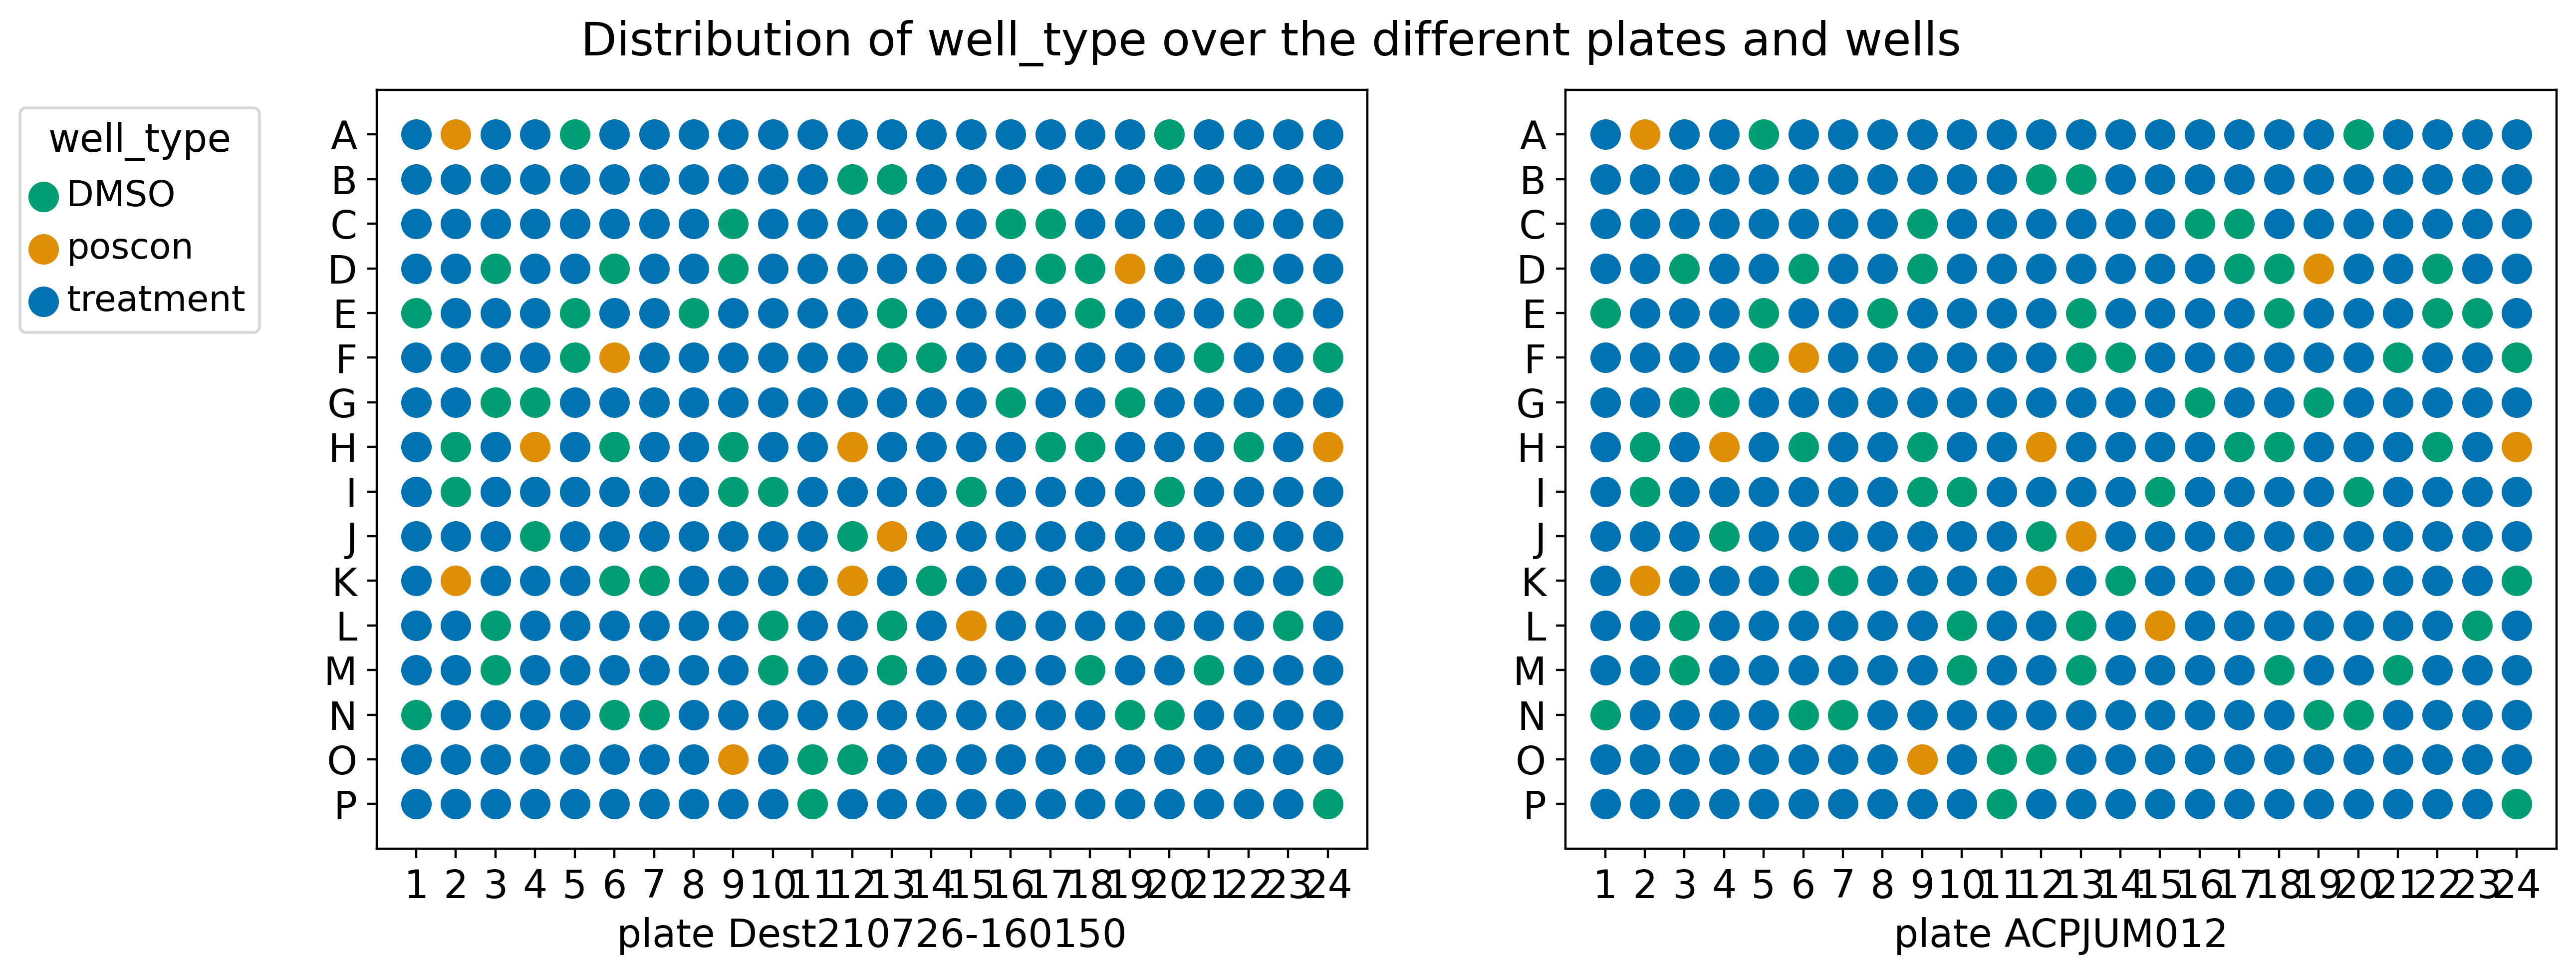

In [6]:
f = plot_well_type_positions(adata.obs[(adata.obs.Metadata_Plate=="ACPJUM012") | (adata.obs.Metadata_Plate=="Dest210726-160150")], "Metadata_Well", "well_type", "Metadata_Plate", 16, 24)

We see that DMSO and poscon samples are in the same plate locations (at least for those 2 sentinel plates which stem from different sources)

## Preprocessing

In [7]:
print(f"Number of inf: {np.sum(np.isinf(adata.X))}")
print(f"Number of nan: {np.sum(np.isnan(adata.X))}")

Number of inf: 33
Number of nan: 5261


We replace `inf` values by `nan` and in a second step, impute `nan` values with the column mean.

In [8]:
adata.X[np.isinf(adata.X)] = np.nan

In [9]:
col_means = np.nanmean(adata.X, axis=0)
nan_indices = np.where(np.isnan(adata.X))
adata.X[nan_indices] = np.take(col_means, nan_indices[1])

### Add Microscope Metadata

In [10]:
micro_filter = pd.read_csv("../../data/jump/microscope_filter.csv")
micro_config = pd.read_csv("../../data/jump/microscope_config.csv")

In [16]:
micro = micro_config.merge(micro_filter, on="Metadata_Filter_Configuration")

In [23]:
micro.Metadata_Source = 'source_' + micro.Metadata_Source.astype(str)

In [27]:
adata.obs = adata.obs.merge(micro, on="Metadata_Source")

### Add Drug Target Metadata